# Botrytis cinerea on hemp models
We will implement two models.

The data comes from ...

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read excel, sort data by date
df = pd.read_csv("data.csv")

plt.rcParams['figure.figsize'] = [15,10]

# Show columns
print("Number of element (hours): ", df["date"].size, "\nColumns: ", df.columns)

Number of element (hours):  1055 
Columns:  Index(['date', 'airsensor_moisture', 'airsensor_temperature',
       'leafsensor_moisture'],
      dtype='object')



## First model
Infection index = ln(Y/(1−Y))=−2.647866−0.374927W+0.061601WT−0.00151WT^2

where : ln(Y/(Y-1)) : logit function of grape infection where Y is the proportion of infected grapes; W: duration of leaf wetness in hours; T: temperature in degrees Celsius.


To be valid, this model considers the assumptions to be true: 

- If the leaf moisture sensor is dry for more than 4 hours, then the model considers the moisture time to be zero and the moisture time accumulation resumes on the next moisture detection. Otherwise, the model combines the moisture time and records that a moisture time interruption has occurred. 
- If the temperature is below 12°C, the model uses the minimum value with which it was calibrated (12°C). 
- If the temperature is between 32°C and 40°C, the model uses the minimum value with which it was calibrated (32°C). 
- If the temperature is higher than 40°C, then it does not allow infection. 
- If the relative humidity is greater than or equal to 95%, then a period of leaf wetness should be assumed to occur even if the leaf wetness sensor does not detect any moisture. 
- If a wet spell lasts more than 16 hours, it is considered severe.

For the implementation: I added a atleast 0.25 leaf moisture because too many alerts were occuring and because the leafsensor always detect humidity on it.

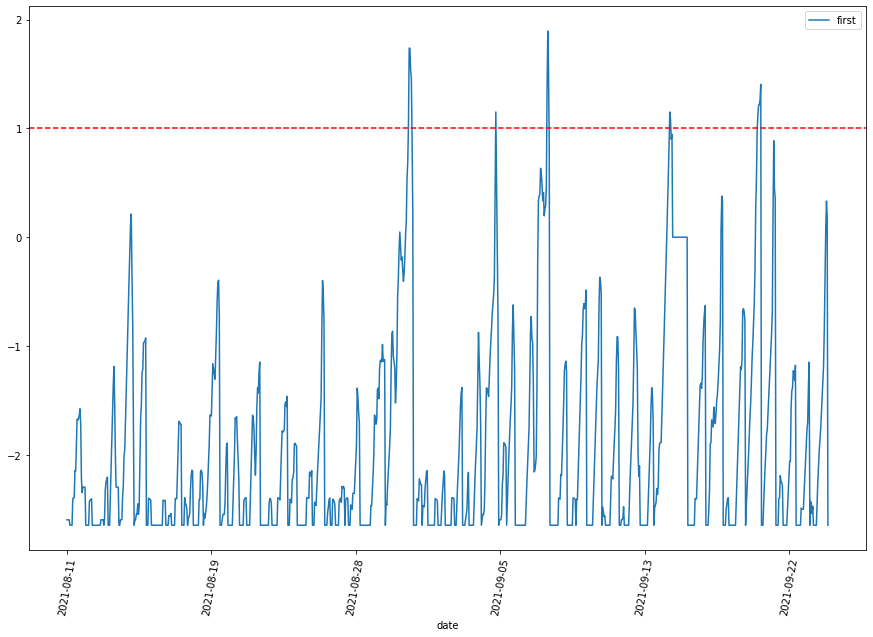

In [85]:
def first_model():
    df['first'] = 0.0  # add a column for our results

    consecutive_leaf_moisture = 0
    consecutive_leaf_dryness = 0

    for i, row in df.iterrows():

        # ignore the incorrect values from 15 to 16 September
        if pd.isna(row.airsensor_moisture):
            continue

        # check it's humid enough (normally it would be when it's 0 for the leaf sensor but it's never the case in our data)
        if row.leafsensor_moisture < 0.25 and row.airsensor_moisture < 90:
            consecutive_leaf_dryness += 1
            if consecutive_leaf_dryness > 3: # if it's not humid enough for 4 hours, cancel streak
                consecutive_leaf_moisture = 0
        else:
            consecutive_leaf_dryness = 0
            consecutive_leaf_moisture += 1 # increment streak when it's humid enough

        # Model work from 12 to 32 °C, above 40 there is no risk of infection 
        temp = row.airsensor_temperature
        if temp < 12:
            temp = 12
        elif temp > 32:
            temp = 32
        elif temp > 40:
            consecutive_leaf_moisture = 0

        # Equation of first model
        df.at[i, 'first'] = -2.647866 - 0.374927 * consecutive_leaf_moisture + 0.061601*consecutive_leaf_moisture * \
            temp - 0.00151*consecutive_leaf_moisture * \
            pow(temp, 2)  # equation


first_model() # Compute model

# Display results
first_model = df.plot(x="date", y="first", rot=80)
xdate = [item.get_text()[:10]
         for item in first_model.get_xticklabels()]
_ = first_model.set_xticklabels(xdate)
_ = plt.axhline(1, color='red', linestyle='--') # there is infection above the red line


## Second model
Nair et al (1993) proposed a statistical model describing the risk of infection of grapes and their flowers. The risk of infection is modeled on the basis of leaf wetness period and incubation temperature data. The model was developed experimentally, incubating flowers and fruits at different temperatures during different humidity periods in a climate chamber.

- Infection = Imax * (1 - exp( - (Q*t/Ktime)^2))
- where Q = exp( - (T - Topt)/Ktemp)^2)

Imax: the maximum proportion of infection; Ktime: time to reach 63% of Imax at Topt when exposed to humidity; Topt: optimal temperature for infection; Ktemp: range of temperatures within which infection can occur; T: temperature in degrees Celsius; t: time in hours

| **Paramètres**   | **Fleurs** | **Fruits** |
| --- | --- | --- |
| **Imax (%)** | 95.6 +/- 1.4  | 100  |
| **Ktime (h)**| 1.3 +/-  0.1  | 13.9 +/-  0.6  |
| **Topt (°C)**| 23.7 +/-  0.5  | 20.8 +/-  0.2  |
| **Ktemp (°C)** | 10.5 +/-  0.3  | 8.9 +/-  0.4  |

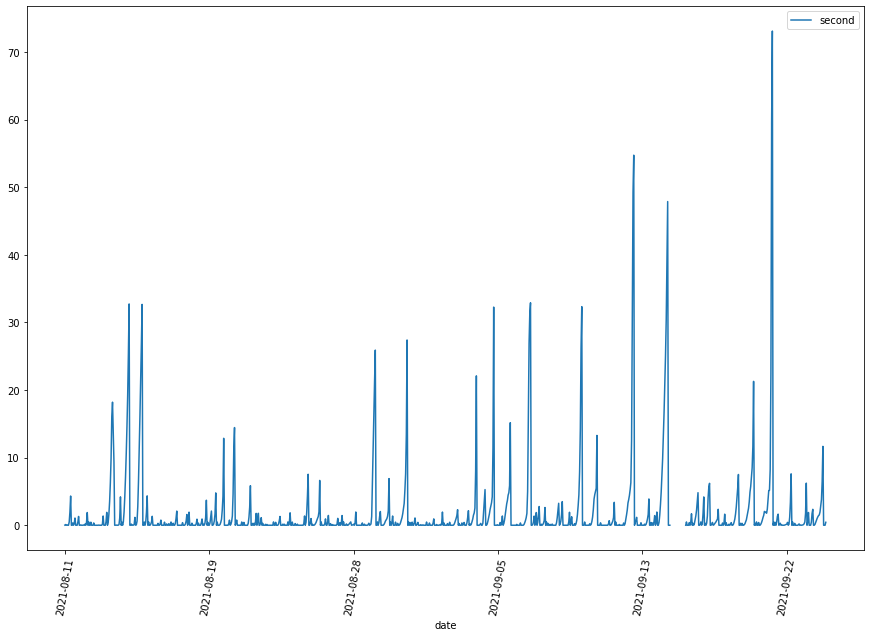

In [86]:
def second_model():
    df['second'] = 0.0  # add a column for our results

    IMAX = 95.6
    KTIME = 13.9 # model doesn't work with 1.3 as mentionned in the Fleurs column so we took Fruits value
    TOPT = 23.7
    KTEMP = 10.5

    consecutive_leaf_moisture = 0

    for i, row in df.iterrows():

        # Check it's humid enough for consecutive humidity
        if row.leafsensor_moisture < 0.2 and row.airsensor_moisture < 90:
            consecutive_leaf_moisture = 0
        else:
            consecutive_leaf_moisture += 1

        # Equation of second model
        Q = np.exp(-pow((row.airsensor_temperature - TOPT)/KTEMP, 2))
        df.at[i, 'second'] = IMAX * (1 - np.exp(-pow(Q*consecutive_leaf_moisture/KTIME, 2)))


second_model() # Compute second model

# Display results
second_model = df.plot(x="date", y="second", rot=80)
_ = second_model.set_xticklabels(xdate)

## Conclusion

These two models have to be adapted according to the results obtained on the field. For now, to get average results I gauged the humidity of the leaf by myself. The models indicate that the leaves should just be wet, but they are wet all the time. Therefore I added a threshold so that the humidity is at least ~0.2.

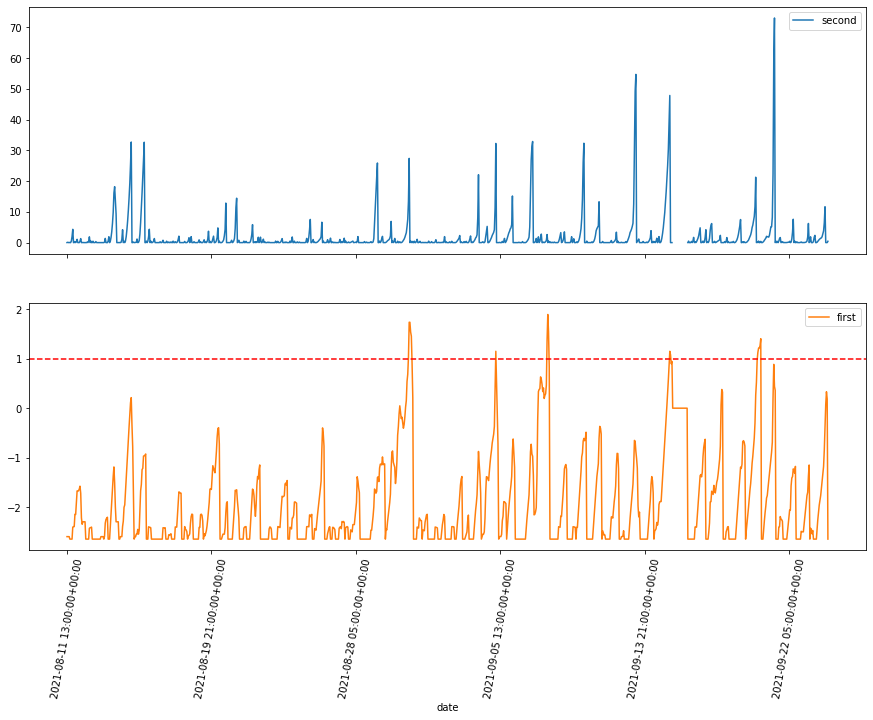

In [89]:
df.to_csv('res.csv')

_ = df.plot(x="date", y=["second", "first"], subplots=True, rot=80)
_ = plt.axhline(1, color='red', linestyle='--') # there is infection above the red line

